In [1]:
import pandas as pd
import numpy as np
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
from __init__ import select, standard_stopwords, read_ldjson, tokenize

In [3]:
if 'chbrown' in plt.style.available:
    plt.style.use('chbrown')

# Inaugural address word count

In [4]:
inaugural_speeches = list(read_ldjson('../data/tapp/inaugurals.json'))

In [5]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)

In [6]:
def iter_rows(speeches, stopwords=None):
    for speech in speeches:
        row = select(speech, {'title', 'author', 'timestamp'})
        total_word_count = sum(1 for _ in tokenize(speech['text']))
        content_word_count = sum(1 for _ in tokenize(speech['text'], stopwords))
        yield dict(total_word_count=total_word_count, 
                   content_word_count=content_word_count, **row)

In [7]:
df = pd.DataFrame(iter_rows(inaugural_speeches, standard_stopwords))
df['timestamp'] = pd.to_datetime(df.timestamp)
df['content_word_proportion'] = df.content_word_count / df.total_word_count

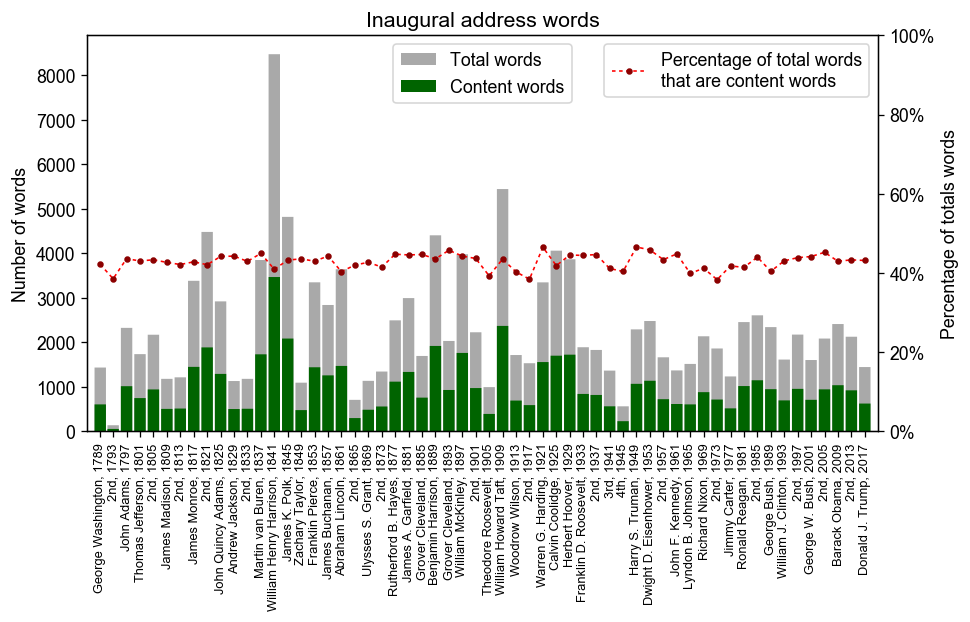

In [10]:
fig = plt.figure(figsize=(8.5, 5.5))
ax = fig.gca()
# matplotlib can't handle np.timestamp64 types
# pandas can't handle dual axes (at least, not well)
# so we meet in the awkward middle
timestamps = df.timestamp.tolist()
term_days = 365*4.0
bar_kwargs = dict(width=term_days * 0.85, snap=False)
ax.bar(timestamps, df.total_word_count, label='Total words', color='darkgray', **bar_kwargs)
ax.bar(timestamps, df.content_word_count, label='Content words', color='darkgreen', **bar_kwargs)
ax.set_ylabel('Number of words')

ax2 = ax.twinx()
ax2.plot(timestamps, df.content_word_proportion, label='Percentage of total words\nthat are content words', 
         marker='.', markeredgecolor='darkred', markerfacecolor='darkred',
         color='red', linewidth=1, linestyle='dotted', alpha=1)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.set_ylim(0, 1.0)
# ax2.set_ylim(0.2, 0.8)
ax2.set_ylabel('Percentage of totals words')

ticklabels = list(get_inaugural_ticklabels(df))
ax.set_xticks(timestamps, minor=False)
ax.set_xticklabels(ticklabels, minor=False, rotation=90, size=8)
ax.set_xlabel('', visible=False)
plt.title('Inaugural address words')
ax.legend(loc='upper center')
ax2.legend(loc='upper right')
term_timedelta = pd.to_timedelta(term_days, 'D')
plt.xlim(timestamps[0] - term_timedelta, timestamps[-1] + term_timedelta)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')